In [19]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

# from seaborn import despine
import matplotlib.pyplot as plt
plt.rc("axes.spines", top=False, right=False)

from analysis_functions import compute_gaze_influence, sci_notation, run_linear_model, compute_mean_rt, compute_p_choose_best, write_summary, make_sure_path_exists

In [20]:
make_sure_path_exists('results/linear_models')

In [21]:
np.random.seed(52) # from random.org

# Absolute model fit (out of sample prediction)
# Full Model vs No Bias Model
## Like and dislike condition

In [22]:
print('Assessing absolute model fit...')

Assessing absolute model fit...


### Load plot function

In [23]:
def plot_correlation(x, y,
                     model_names=None,
                     xlabel='',
                     ylabel='',
                     title='',
                     ci=0.95,
                     xticks=None,
                     yticks=None,
                     xticklabels=None,
                     yticklabels=None,
                     xlim=None,
                     ylim=None,
                     annotation_pos=(0.1, 0.1),
                     annotation_halign='left',
                     fontsize_title=15,
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_annotation=12,
                     plot_diagonal=False,
                     ax=None):

    # Defaults
    if ax is None:
        fig, ax = plt.subplots()
    if not isinstance(y, list):
        y = [y]
    if model_names is None:
        model_names = ['Model {}'.format(i)
                       for i in range(len(y))]
    
    for i, yi in enumerate(y):
        # Scatter
        ax.scatter(x, yi, color='C{}'.format(i), alpha=0.5)

        # LM fit
        X = sm.add_constant(x)
        lm = sm.OLS(yi, X).fit()
        intercept, slope = lm.params
        table, data, columns = summary_table(lm, alpha=1.-ci)
        predicted, mean_ci_lower, mean_ci_upper = data[:, np.array([2, 4, 5])].T

         # Annotation
        tval = lm.tvalues[-1]
        pval = lm.pvalues[-1]
        if pval < 0.01:
            pstring = ' < ' + sci_notation(pval, decimal_digits=2)
        else:
            pstring = ' = {:.2f}'.format(pval)
        r = np.sign(tval) * np.sqrt(lm.rsquared)
        label = ((r'$r = {:.2f}$, '.format(r)) +
                  r'$P${}'.format(pstring))
        xs = np.linspace(*ax.get_xlim(), 100)
        ax.plot(xs, intercept + slope * xs,
                color='C{}'.format(i), label=label)
        sort_idx = np.argsort(x)
        ax.fill_between(x[sort_idx], mean_ci_lower[sort_idx], mean_ci_upper[sort_idx],
                        color='C{}'.format(i), alpha=0.1)

    ax.legend(loc='best', fontsize=fontsize_annotation, frameon=False)

    # Axes, ticks, ...
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
        
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, fontsize=fontsize_ticklabels)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels, fontsize=fontsize_ticklabels)

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Diagonal
    if plot_diagonal:
        ax.plot([0, 1], [0, 1], transform=ax.transAxes,
                color='black', alpha=.5, zorder=-10, lw=2)

    # Labels
    ax.set_xlabel(xlabel, fontsize=fontsize_axeslabel)
    ax.set_ylabel(ylabel, fontsize=fontsize_axeslabel)
    ax.set_title(title, fontsize=fontsize_title)
#     despine()

    return ax

# LIKE CONDITION

## Load *observed* data (test set) GLAM out of sample *predictions*

In [24]:
#Like
test_data = pd.read_csv('data/FF2018_data/GlamDataFF2018_preprocessed_test_Like_NoBin_NUTS.csv')
#Dislike
#test_data = pd.read_csv('data/FF2018_data/GlamDataFF2018_preprocessed_test_Dislike_FixBin5_InvInputDislike_NUTS.csv')

#Like
glam_full = pd.read_csv('results/predictions/glam_FF2018_full_hierarchical_cv_Like_NoBin_NUTS.csv')
glam_nobias = pd.read_csv('results/predictions/glam_FF2018_nobias_hierarchical_cv_Like_NoBin_NUTS.csv')

#Dislike
#glam_full = pd.read_csv('results/predictions/glam_FF2018_full_hierarchical_cv_Dislike_FixBin5_InvInputDislike_NUTS.csv')
#glam_nobias = pd.read_csv('results/predictions/glam_FF2018_nobias_hierarchical_cv_Dislike_FixBin5_InvInputDislike_NUTS.csv')

# Compute behavioral indices for observed data and predictions

In [25]:
mean_rt = pd.DataFrame(dict(observed=compute_mean_rt(test_data),
                            glam_full=compute_mean_rt(glam_full),
                            glam_nobias=compute_mean_rt(glam_nobias)))

p_choose_best = pd.DataFrame(dict(observed=compute_p_choose_best(test_data),
                            glam_full=compute_p_choose_best(glam_full),
                            glam_nobias=compute_p_choose_best(glam_nobias)))

gaze_influence = pd.DataFrame(dict(observed=compute_gaze_influence(test_data),
                                   glam_full=compute_gaze_influence(glam_full),
                                   glam_nobias=compute_gaze_influence(glam_nobias)))

## Linear models: Are out of sample data predicted by GLAM variants?

### 1. Full GLAM

#### 1.1 Mean RT

In [26]:
print('  1. Full GLAM...')
print('  1.1 Mean RT')
_ = run_linear_model(mean_rt['glam_full'],
                     mean_rt['observed'])
write_summary(_, 'results/linear_models/like/3_absfit_fullglam_rt.csv')

  1. Full GLAM...
  1.1 Mean RT
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     331.0
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           4.23e-18
Time:                        20:51:31   Log-Likelihood:                -227.23
No. Observations:                  33   AIC:                             458.5
Df Residuals:                      31   BIC:                             461.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -383.940

#### 1.2 P(choose best)

In [27]:
print('  1.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_full'],
                     p_choose_best['observed'])
write_summary(_, 'results/linear_models/like/3_absfit_fullglam_pchoosebest.csv')

  1.2 P(choose best)
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     92.57
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           8.00e-11
Time:                        20:51:31   Log-Likelihood:                 44.988
No. Observations:                  33   AIC:                            -85.98
Df Residuals:                      31   BIC:                            -82.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0144      0.07

#### 1.3 Gaze influence on P(choose left)

In [28]:
print('  1.3 Gaze Influence')
_ = run_linear_model(gaze_influence['glam_full'],
                     gaze_influence['observed'])
write_summary(_, 'results/linear_models/like/3_absfit_fullglam_gazeinfluence.csv')

  1.3 Gaze Influence
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     45.54
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           1.49e-07
Time:                        20:51:31   Log-Likelihood:                 19.809
No. Observations:                  33   AIC:                            -35.62
Df Residuals:                      31   BIC:                            -32.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1062      0.04

### 2. No-Bias GLAM

#### 2.1 Mean RT

In [29]:
print('  2. No-Bias GLAM')
print('  2.1 Mean RT')
_ = run_linear_model(mean_rt['glam_nobias'],
                     mean_rt['observed'])
write_summary(_, 'results/linear_models/like/3_absfit_nobias_rt.csv')

  2. No-Bias GLAM
  2.1 Mean RT
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     32.11
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           3.18e-06
Time:                        20:51:31   Log-Likelihood:                -256.06
No. Observations:                  33   AIC:                             516.1
Df Residuals:                      31   BIC:                             519.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1030.

#### 2.2 P(choose best)

In [30]:
print('  2.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_nobias'],
                     p_choose_best['observed'])
write_summary(_, 'results/linear_models/like/3_absfit_nobias_pchoosebest.csv')

  2.2 P(choose best)
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     27.73
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           1.00e-05
Time:                        20:51:31   Log-Likelihood:                 32.715
No. Observations:                  33   AIC:                            -61.43
Df Residuals:                      31   BIC:                            -58.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1218      0

#### 2.3 Gaze influence on P(choose left)

In [31]:
print('  2.3 Gaze influence')
_ = run_linear_model(gaze_influence['glam_nobias'],
                     gaze_influence['observed'])
write_summary(_, 'results/linear_models/like/3_absfit_nobias_gazeinfluence.csv')

  2.3 Gaze influence
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8529
Date:                Tue, 27 Nov 2018   Prob (F-statistic):              0.363
Time:                        20:51:31   Log-Likelihood:                 5.3441
No. Observations:                  33   AIC:                            -6.688
Df Residuals:                      31   BIC:                            -3.695
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4016      0

# Figure 5

In [32]:
def figure_5(mean_rt, p_choose_best, gaze_influence, figsize=(10, 3.5)):

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    plot_correlation(mean_rt['observed'].values,
                     [mean_rt['glam_full'].values, mean_rt['glam_nobias'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='Mean RT (ms)',
                     xlim=[0, 6500],
                     ylim=[0, 6500],
                     xticks=np.arange(0, 7000, 1000),
                     yticks=np.arange(0, 7000, 1000),
                     xticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     yticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[0], plot_diagonal=True)

    plot_correlation(p_choose_best['observed'].values,
                     [p_choose_best['glam_full'].values, p_choose_best['glam_nobias'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='P(choose best)',
                     xlim=[0.45, 1.05],
                     ylim=[0.45, 1.05],
                     xticks=np.arange(0.4, 1.1, 0.1),
                     yticks=np.arange(0.4, 1.1, 0.1),
                     xticklabels=['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                     yticklabels=['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[1], plot_diagonal=True)

    plot_correlation(gaze_influence['observed'].values,
                     [gaze_influence['glam_full'].values, gaze_influence['glam_nobias'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='Gaze influence\non P(choose left)',
                     xticks=np.arange(-0.1, 0.7, 0.1),
                     yticks=np.arange(-0.1, 0.7, 0.1),
                     xticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     yticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     xlim=[-0.125, 0.625],
                     ylim=[-0.125, 0.625],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[2], plot_diagonal=True)

    # index axes
    for label, ax in zip(list('ABC'), axs.ravel()):
        ax.text(-0.1, 1.15, label, transform=ax.transAxes,
                fontsize=20, fontweight='bold', va='top')

    fig.tight_layout()

    return None

Close Figure to continue...


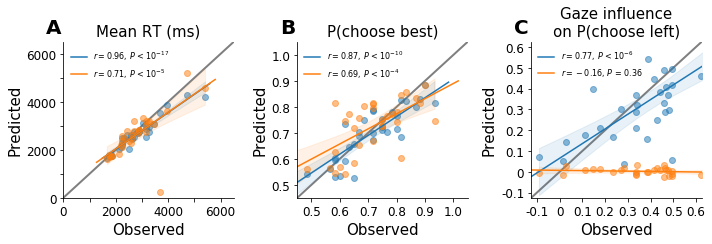

In [33]:
print('Close Figure to continue...')
figure_5(mean_rt, p_choose_best, gaze_influence)
plt.savefig('SavedFigures/Like_model_fit_simulations.png', dpi=330, bbox_inches='tight')
plt.show()

Model predictions are simulated from hierarchically estimated parameter estimates. Blue color indicates predictions from the full GLAM, whereas orange indicates predictions from a restricted GLAM variant with no gaze bias (gamma = 1).


# DISLIKE CONDITION

## Load *observed* data (test set) GLAM out of sample *predictions*

In [34]:
#Like
#test_data = pd.read_csv('data/FF2018_data/GlamDataFF2018_preprocessed_test_Like_FixBin5_NUTS.csv')
#Dislike
test_data = pd.read_csv('data/FF2018_data/GlamDataFF2018_preprocessed_test_Dislike_NoBin_InvInputDislike_NUTS.csv')

#Like
#glam_full = pd.read_csv('results/predictions/glam_FF2018_full_hierarchical_cv_Like_FixBin5_NUTS.csv')
#glam_nobias = pd.read_csv('results/predictions/glam_FF2018_nobias_hierarchical_cv_Like_FixBin5_NUTS.csv')

#Dislike
glam_full = pd.read_csv('results/predictions/glam_FF2018_full_hierarchical_cv_Dislike_NoBin_InvInputDislike_NUTS.csv')
glam_nobias = pd.read_csv('results/predictions/glam_FF2018_nobias_hierarchical_cv_Dislike_NoBin_InvInputDislike_NUTS.csv')

# Compute behavioral indices for observed data and predictions

In [35]:
mean_rt = pd.DataFrame(dict(observed=compute_mean_rt(test_data),
                            glam_full=compute_mean_rt(glam_full),
                            glam_nobias=compute_mean_rt(glam_nobias)))

p_choose_best = pd.DataFrame(dict(observed=compute_p_choose_best(test_data),
                            glam_full=compute_p_choose_best(glam_full),
                            glam_nobias=compute_p_choose_best(glam_nobias)))

gaze_influence = pd.DataFrame(dict(observed=compute_gaze_influence(test_data),
                                   glam_full=compute_gaze_influence(glam_full),
                                   glam_nobias=compute_gaze_influence(glam_nobias)))

## Linear models: Are out of sample data predicted by GLAM variants?

### 1. Full GLAM

#### 1.1 Mean RT

In [36]:
print('  1. Full GLAM...')
print('  1.1 Mean RT')
_ = run_linear_model(mean_rt['glam_full'],
                     mean_rt['observed'])
write_summary(_, 'results/linear_models/dislike/3_absfit_fullglam_rt.csv')

  1. Full GLAM...
  1.1 Mean RT
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     167.6
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           4.83e-14
Time:                        20:51:36   Log-Likelihood:                -232.20
No. Observations:                  33   AIC:                             468.4
Df Residuals:                      31   BIC:                             471.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.492

#### 1.2 P(choose best)

In [37]:
print('  1.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_full'],
                     p_choose_best['observed'])
write_summary(_, 'results/linear_models/dislike/3_absfit_fullglam_pchoosebest.csv')

  1.2 P(choose best)
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     93.51
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           7.10e-11
Time:                        20:51:36   Log-Likelihood:                 42.932
No. Observations:                  33   AIC:                            -81.86
Df Residuals:                      31   BIC:                            -78.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0452      0.07

#### 1.3 Gaze influence on P(choose left)

In [38]:
print('  1.3 Gaze Influence')
_ = run_linear_model(gaze_influence['glam_full'],
                     gaze_influence['observed'])
write_summary(_, 'results/linear_models/dislike/3_absfit_fullglam_gazeinfluence.csv')

  1.3 Gaze Influence
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     30.56
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           4.72e-06
Time:                        20:51:37   Log-Likelihood:                 16.489
No. Observations:                  33   AIC:                            -28.98
Df Residuals:                      31   BIC:                            -25.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0579      0.06

### 2. No-Bias GLAM

#### 2.1 Mean RT

In [39]:
print('  2. No-Bias GLAM')
print('  2.1 Mean RT')
_ = run_linear_model(mean_rt['glam_nobias'],
                     mean_rt['observed'])
write_summary(_, 'results/linear_models/dislike/3_absfit_nobias_rt.csv')

  2. No-Bias GLAM
  2.1 Mean RT
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     161.5
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           7.85e-14
Time:                        20:51:37   Log-Likelihood:                -232.71
No. Observations:                  33   AIC:                             469.4
Df Residuals:                      31   BIC:                             472.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -232.

#### 2.2 P(choose best)

In [40]:
print('  2.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_nobias'],
                     p_choose_best['observed'])
write_summary(_, 'results/linear_models/dislike/3_absfit_nobias_pchoosebest.csv')

  2.2 P(choose best)
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     50.36
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           5.67e-08
Time:                        20:51:37   Log-Likelihood:                 35.912
No. Observations:                  33   AIC:                            -67.82
Df Residuals:                      31   BIC:                            -64.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0039      0

#### 2.3 Gaze influence on P(choose left)

In [41]:
print('  2.3 Gaze influence')
_ = run_linear_model(gaze_influence['glam_nobias'],
                     gaze_influence['observed'])
write_summary(_, 'results/linear_models/dislike/3_absfit_nobias_gazeinfluence.csv')

  2.3 Gaze influence
                            OLS Regression Results                            
Dep. Variable:               observed   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.2573
Date:                Tue, 27 Nov 2018   Prob (F-statistic):              0.616
Time:                        20:51:37   Log-Likelihood:                 5.3050
No. Observations:                  33   AIC:                            -6.610
Df Residuals:                      31   BIC:                            -3.617
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3740      0

# Figure 5

Close Figure to continue...


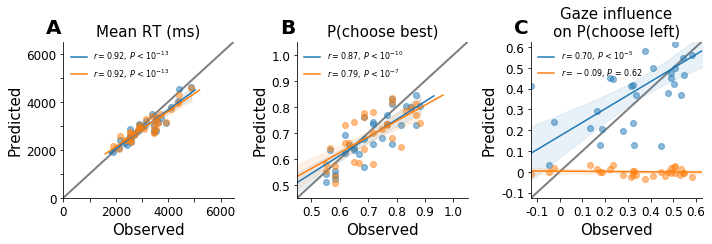

In [42]:
print('Close Figure to continue...')
figure_5(mean_rt, p_choose_best, gaze_influence)
plt.savefig('SavedFigures/Dislike_model_fit_simulations.png', dpi=330, bbox_inches='tight')
plt.show()

Model predictions are simulated from hierarchically estimated parameter estimates. Blue color indicates predictions from the full GLAM, whereas orange indicates predictions from a restricted GLAM variant with no gaze bias (gamma = 1).
